In [159]:
import pandas as pd
import numpy as np
from data_prepare import zero_to_mean, zero_to_nan

df = pd.read_csv("./data/diabetes.csv")

target = "Outcome"
labels = df[target]
df = df.drop(columns=[target, "Pregnancies"])

num_cols = df.columns # "X"
non_zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Pipeline

In [250]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# zero_to_mean(df)
non_zero_pipeline = Pipeline([
    ('impute_zero_to_nan', FunctionTransformer(zero_to_nan)),
    ('imputer', SimpleImputer(strategy='mean')),
])

pre_imputation = ColumnTransformer(
    transformers=[
        ('non_zero_clean', non_zero_pipeline, non_zero_cols),
    ],
    remainder='passthrough' # tudo que não for non_zero_cols passa sem mexer
)

def boost_glucose(X):
    X[:, 0] *= 20  # Assume que Glucose será a primeira no pipeline após o ColumnTransformer
    return X

def boost_bmi(X):
    X[:, 4] *= 10  # Assume que Glucose será a primeira no pipeline após o ColumnTransformer
    return X

def boost_insulin(X):
    X[:, 4] *= 20  # Assume que Glucose será a primeira no pipeline após o ColumnTransformer
    return X

def clip_outliers_quantile(X: pd.DataFrame, lower=0.01, upper=0.99):
    X = X.copy()
    cols_to_clip = ['Insulin', 'SkinThickness']

    for col in cols_to_clip:
        q_low = X[col].quantile(lower)
        q_high = X[col].quantile(upper)
        X[col] = X[col].clip(lower=q_low, upper=q_high)

    return X

boost_glucose_transformer = FunctionTransformer(boost_glucose)
boost_bmi_transformer = FunctionTransformer(boost_bmi)
boost_insulin_transformer = FunctionTransformer(boost_insulin)

# clipper = FunctionTransformer(
#     lambda X: pd.DataFrame(
#         clip_outliers_quantile(
#             pd.DataFrame(X, columns=num_cols),
#             upper=0.4
#         ),
#         columns=num_cols
#     )
# )

preprocessor = Pipeline([
    ('pre_clean', pre_imputation),
    # ('clip_outliers', clipper),
    # ('scaler', StandardScaler()),
    ('minMax', MinMaxScaler()),
    # ('glucose_scaler', glucose_scaler),
    # ('powerTransformer', PowerTransformer()),
    # ('robust', RobustScaler()),
    ('boost_glucose', boost_glucose_transformer),
    # ('boost_bmi', boost_bmi_transformer),
    ('boost_insulin', boost_insulin_transformer),
])

np.int64(0)

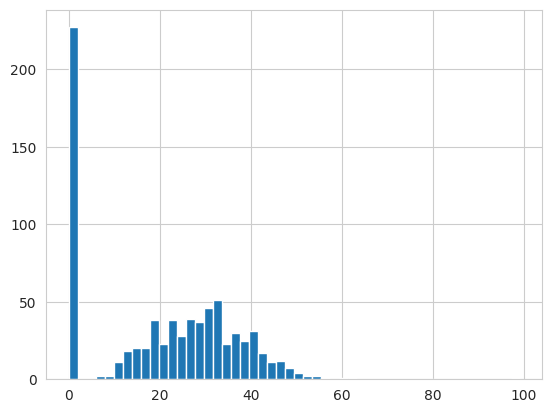

In [107]:
dfn = clip_outliers_quantile(df, lower=0.2)
df['SkinThickness'].hist(bins=50)
# df['SkinThickness'].min()

# Methods - Prepare

In [249]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def stratify(df: pd.DataFrame, target: pd.DataFrame):
    train_set, test_set, train_labels, test_labels = train_test_split(
        df,
        target,
        test_size = 0.20,
        random_state = 42,
        stratify=target,
    )

    return train_set, train_labels, test_set, test_labels

def prepare_train(df: pd.DataFrame):
    prepared_data = preprocessor.fit_transform(df)

    df_transformed = pd.DataFrame(
        prepared_data,
        columns=num_cols,
        index=df.index,
    )

    return df_transformed

def prepare_predict(df: pd.DataFrame, all_feature_names: list):
    prepared_data = preprocessor.transform(df)
    df_transformed = pd.DataFrame(
        prepared_data,
        columns=all_feature_names,
        index=df.index
    )

    return df_transformed

def model_exc(
        model,
        train_prepared: pd.DataFrame,
        train_labels: pd.DataFrame,
        test_set: pd.DataFrame,
        test_labels: pd.DataFrame,
        cols: list,
):
    model.fit(train_prepared, train_labels)

    test_prepared = prepare_predict(test_set, cols)

    # predictions = model.predict(test_prepared)
    predictions = model.predict_proba(test_prepared)[:, 1]

    # Por que reduzir o limiar (threshold) aumenta recall e parece melhorar o modelo?
    # Modelos de classificação como o RandomForest retornam probabilidades.
    # Padrão (0.5), se a probabilidade for > 0.5 → classe 1 (diabetes), senão → classe 0.
    # reduzir o limiar para 0.2, está dizendo:
    # “Se a chance de ser positivo for maior que 20%, já considero como positivo (classe 1).”
    #
    # Isso aumenta o número de positivos detectados (recall), porque você está sendo mais sensível.
    threshold = 0.25
    y_pred_custom = (predictions >= threshold).astype(int)

    # print('ModelScore: ', model.score(test_prepared, test_labels))
    results = evaluate(test_labels, y_pred_custom)
    # print(results)
    return results

def evaluate(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred), # prever negativos
        'recall': recall_score(y_true, y_pred), # prever positivos
        'f1_score': f1_score(y_true, y_pred) # equilíbrio precisão vs recall
    }

# Ver o step de conversão de ZEROS para médias
 apenas para garantir que está funcionando

In [26]:
# Ver o step intermediário para garantir que os valores ZERO foram convertidos para média
intermediate = preprocessor.named_steps['powerTransformer'].fit_transform(df)
intermediate_df = pd.DataFrame(
    intermediate,
    columns=num_cols
)
intermediate_df["Glucose"].describe()

count    7.680000e+02
mean     4.209596e-16
std      1.000652e+00
min     -3.898273e+00
25%     -6.815906e-01
50%     -1.170451e-01
75%      6.079309e-01
max      2.423256e+00
Name: Glucose, dtype: float64

In [251]:
train_set, train_labels, test_set, test_labels = stratify(df, labels)
# print("Proporção no treino:", train_set.value_counts(normalize=True))
# print("##################################################################")
# print("Proporção no teste:", test_set.value_counts(normalize=True))
train_prepared = prepare_train(train_set)

In [191]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold # Importe GridSearchCV e StratifiedKFold

# O GridSearchCV faz o seguinte:
# Você define um "grid" (grade) de valores que deseja testar para cada hiperparâmetro.
# Ele testa todas as combinações possíveis desses valores.
# Para cada combinação, ele realiza uma validação cruzada (como o StratifiedKFold que você já implementou) nos seus dados de treino.
# Ele avalia o desempenho de cada combinação usando uma métrica de pontuação que você especificar (ex: recall, f1-score).
#
# No final, ele retorna o modelo com a melhor combinação de hiperparâmetros para a métrica escolhida.
def grid(X_test, X_train, y_train, y_test, model, param_grid):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=skf,           # Estratégia de validação cruzada
        scoring='recall',         # A métrica que você quer otimizar! (Ou 'f1_weighted', 'roc_auc')
        verbose=2,                # Nível de verbosidade (0=silencioso, 1=pouco, 2=completo)
        n_jobs=-1                 # Usa todos os núcleos da CPU disponíveis para acelerar
    )

    print("Iniciando o GridSearchCV...")
    grid_search.fit(X_train, y_train) # GridSearchCV treina nas combinações de hiperparâmetros usando X_train e y_train

    # --- 8. Analisar os Resultados do Ajuste Fino ---
    print("\n--- Resultados do GridSearchCV ---")
    print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")
    print(f"Melhor pontuação (Recall) na validação cruzada: {grid_search.best_score_:.4f}")

    # Obter o melhor modelo treinado
    best_model = grid_search.best_estimator_

    # --- 9. Avaliar o Melhor Modelo nos Dados de Teste (não vistos durante o tuning) ---
    print("\n--- Avaliação Final do Melhor Modelo no Conjunto de Teste ---")
    # Previsões de probabilidade para ajustar o limiar
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Definir o limiar (pode ser ajustado com base na curva ROC/Precision-Recall)
    custom_threshold = 0.25 # Mantenha seu limiar otimizado de antes

    # Converter probabilidades para classes binárias com o limiar personalizado
    y_pred_custom = (y_pred_proba >= custom_threshold).astype(int)

    # Avaliar com as métricas que você já usa
    final_metrics = evaluate(y_test, y_pred_custom)

    print("Avaliação do Modelo:")
    print(f"Acurácia: {final_metrics['accuracy']:.4f}")
    print(f"Precisão: {final_metrics['precision']:.4f}")
    print(f"Recall: {final_metrics['recall']:.4f}")
    print(f"F1-Score: {final_metrics['f1_score']:.4f}")

from sklearn.ensemble import RandomForestClassifier

grid(
    test_set,
    train_set,
    train_labels,
    test_labels,
    RandomForestClassifier(),
    param_grid = {
        'n_estimators': [5,14],
        'class_weight': ['balanced', None]
    }
)

Iniciando o GridSearchCV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..............class_weight=balanced, n_estimators=5; total time=   0.0s
[CV] END ..............class_weight=balanced, n_estimators=5; total time=   0.0s
[CV] END ..............class_weight=balanced, n_estimators=5; total time=   0.0s
[CV] END ..............class_weight=balanced, n_estimators=5; total time=   0.0s
[CV] END ..............class_weight=balanced, n_estimators=5; total time=   0.0s
[CV] END ..................class_weight=None, n_estimators=5; total time=   0.0s
[CV] END ..................class_weight=None, n_estimators=5; total time=   0.0s
[CV] END ..................class_weight=None, n_estimators=5; total time=   0.0s
[CV] END ..................class_weight=None, n_estimators=5; total time=   0.0s
[CV] END ..................class_weight=None, n_estimators=5; total time=   0.0s
[CV] END .............class_weight=balanced, n_estimators=14; total time=   0.0s
[CV] END ............

/home/felipe/projects/tech-challenge/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/felipe/projects/tech-challenge/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/felipe/projects/tech-challenge/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unp

In [179]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def cross(model, x, y, skf):
    return cross_val_score(model, x, y, cv=skf, scoring='accuracy')

def AplicaValidacaoCruzada(X, y, n_splits=10):
    # Escalar os dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # StratifiedKFold para manter proporção das classes
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Modelos
    knn = KNeighborsClassifier(n_neighbors=9, metric='cosine', weights='distance')
    svm = SVC(probability=True, random_state=42)
    rf = RandomForestClassifier(random_state=7, class_weight='balanced')

    # Cross-validation (usa acurácia por padrão)
    knn_scores = cross(knn, X_scaled, y, skf)
    svm_scores = cross(svm, X_scaled, y, skf)
    rf_scores = cross(rf, X_scaled, y, skf)
    # knn_scores = cross_val_score(knn, X_scaled, y, cv=skf, scoring='f1')
    # svm_scores = cross_val_score(svm, X_scaled, y, cv=skf)
    # rf_scores = cross_val_score(rf, X_scaled, y, cv=skf)

    dic_models = {
        "KNN": knn_scores.mean(),
        "SVM": svm_scores.mean(),
        "Random Forest": rf_scores.mean()
    }

    melhorModelo = max(dic_models, key=dic_models.get)

    print(f"KNN (Accuracy): {knn_scores.mean():.4f}")
    print(f"SVM (Accuracy): {svm_scores.mean():.4f}")
    print(f"Random Forest (Accuracy): {rf_scores.mean():.4f}")
    print(f"O melhor modelo é: {melhorModelo} com valor: {dic_models[melhorModelo]:.4f}")

AplicaValidacaoCruzada(df, labels)

KNN (Accuracy): 0.7578
SVM (Accuracy): 0.7695
Random Forest (Accuracy): 0.7668
O melhor modelo é: SVM com valor: 0.7695


In [216]:
def cross_validation_all(x, y):
    # --- 4. Configurando o StratifiedKFold ---
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Lista para armazenar os dicionários de métricas de cada fold
    all_fold_metrics = []

    # --- 5. O Loop de Validação Cruzada ---
    for fold_idx, (train_index, test_index) in enumerate(kfold.split(x, y)):
        print(f"\n--- Processando Fold {fold_idx + 1}/{kfold.n_splits} ---")

        # Dividir os dados em treino e teste para o fold atual
        train_set, test_set = x.iloc[train_index], x.iloc[test_index]
        train_labels, test_labels = y.iloc[train_index], y.iloc[test_index]

        # Treinar o pipeline no fold de treino
        df_trained = prepare_train(train_set)
        # preprocessor.fit(X_train, y_train)
        #
        # # Fazer previsões de probabilidade no fold de teste
        # y_pred_proba = preprocessor.predict_proba(X_test)[:, 1]

        fold_results = model_exc(
            # RandomForestClassifier(n_estimators=14, class_weight="balanced"),
            GradientBoostingClassifier(n_estimators=9, learning_rate=0.8, max_depth=1, random_state=42),
            df_trained,
            train_labels,
            test_set,
            test_labels,
            num_cols,
        )

        #
        # # Aplicar o limiar personalizado
        # custom_threshold = 0.25 # Você pode experimentar com este valor
        # y_pred_custom = (y_pred_proba >= custom_threshold).astype(int)
        #
        # # Avaliar e armazenar as métricas deste fold
        # fold_results = evaluate(test_labels, y_pred_custom)
        all_fold_metrics.append(fold_results)
        print(f"Resultados do Fold {fold_idx + 1}:")
        print(f"  Acurácia: {fold_results['accuracy']:.4f}")
        print(f"  Precisão: {fold_results['precision']:.4f}")
        print(f"  Recall: {fold_results['recall']:.4f}")
        print(f"  F1-Score: {fold_results['f1_score']:.4f}")
        # print("  Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_custom))

    # --- 6. Comparar e Analisar os Resultados Finais ---

    # Converter a lista de dicionários em um DataFrame para fácil análise
    metrics_df = pd.DataFrame(all_fold_metrics)
    #
    print("\n--- Resultados Detalhados por Fold ---")
    print(metrics_df.to_string(float_format='%.4f'))
    #
    print("\n--- Resultados Finais (Desvio Padrão dos Folds) ---")
    # print(metrics_df.mean().rename('Média').to_string(float_format='%.4f'))
    print(metrics_df.std().rename('Desvio Padrão').to_string(float_format='%.4f'))

cross_validation_all(df, labels)


--- Processando Fold 1/5 ---
Resultados do Fold 1:
  Acurácia: 0.7338
  Precisão: 0.5942
  Recall: 0.7593
  F1-Score: 0.6667

--- Processando Fold 2/5 ---
Resultados do Fold 2:
  Acurácia: 0.7597
  Precisão: 0.6269
  Recall: 0.7778
  F1-Score: 0.6942

--- Processando Fold 3/5 ---
Resultados do Fold 3:
  Acurácia: 0.7273
  Precisão: 0.5769
  Recall: 0.8333
  F1-Score: 0.6818

--- Processando Fold 4/5 ---
Resultados do Fold 4:
  Acurácia: 0.7190
  Precisão: 0.5676
  Recall: 0.7925
  F1-Score: 0.6614

--- Processando Fold 5/5 ---
Resultados do Fold 5:
  Acurácia: 0.6275
  Precisão: 0.4778
  Recall: 0.8113
  F1-Score: 0.6014

--- Resultados Detalhados por Fold ---
   accuracy  precision  recall  f1_score
0    0.7338     0.5942  0.7593    0.6667
1    0.7597     0.6269  0.7778    0.6942
2    0.7273     0.5769  0.8333    0.6818
3    0.7190     0.5676  0.7925    0.6614
4    0.6275     0.4778  0.8113    0.6014

--- Resultados Finais (Desvio Padrão dos Folds) ---
accuracy    0.0504
precision   

In [252]:
from sklearn.ensemble import RandomForestClassifier

model_exc(
    RandomForestClassifier(n_estimators=14, class_weight="balanced", random_state=42),
    train_prepared,
    train_labels,
    test_set,
    test_labels,
    num_cols,
)

{'accuracy': 0.7272727272727273,
 'precision': 0.5714285714285714,
 'recall': 0.8888888888888888,
 'f1_score': 0.6956521739130435}

In [253]:
from sklearn.ensemble import GradientBoostingClassifier

model_exc(
    GradientBoostingClassifier(n_estimators=9, learning_rate=0.8, max_depth=1, random_state=42),
    train_prepared,
    train_labels,
    test_set,
    test_labels,
    num_cols,
)

{'accuracy': 0.7532467532467533,
 'precision': 0.6,
 'recall': 0.8888888888888888,
 'f1_score': 0.7164179104477612}

Text(0.5, 1.0, 'Mapa de Correlação')

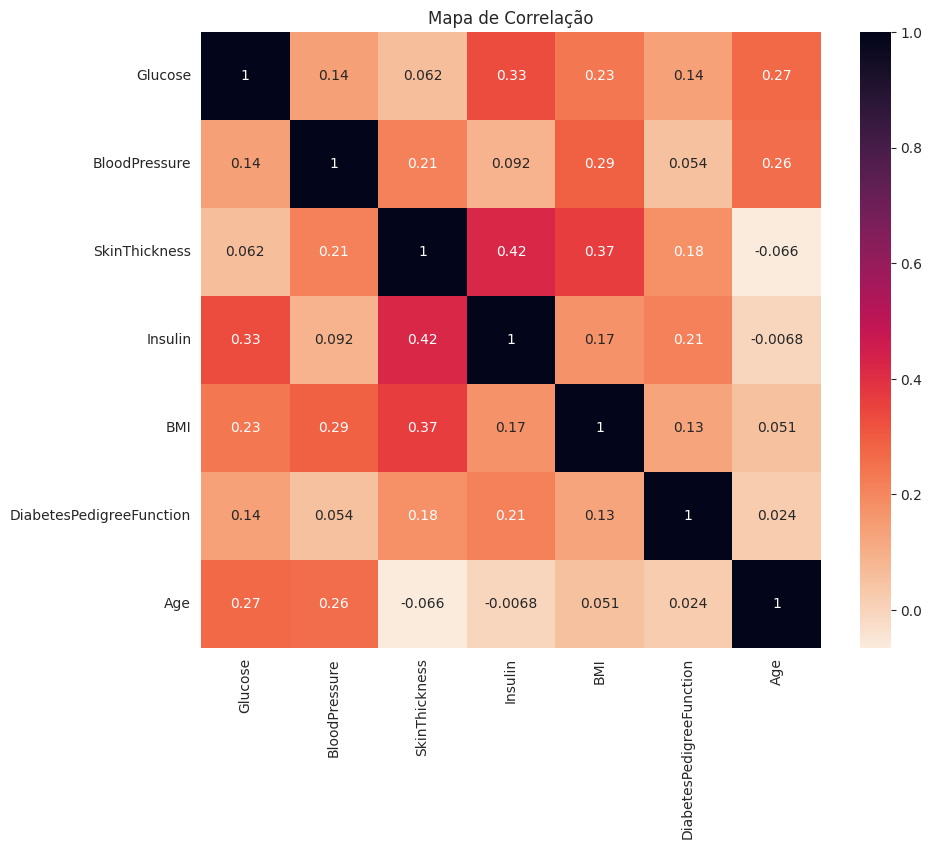

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(train_set.corr(), annot=True, cmap='rocket_r')
plt.title('Mapa de Correlação')

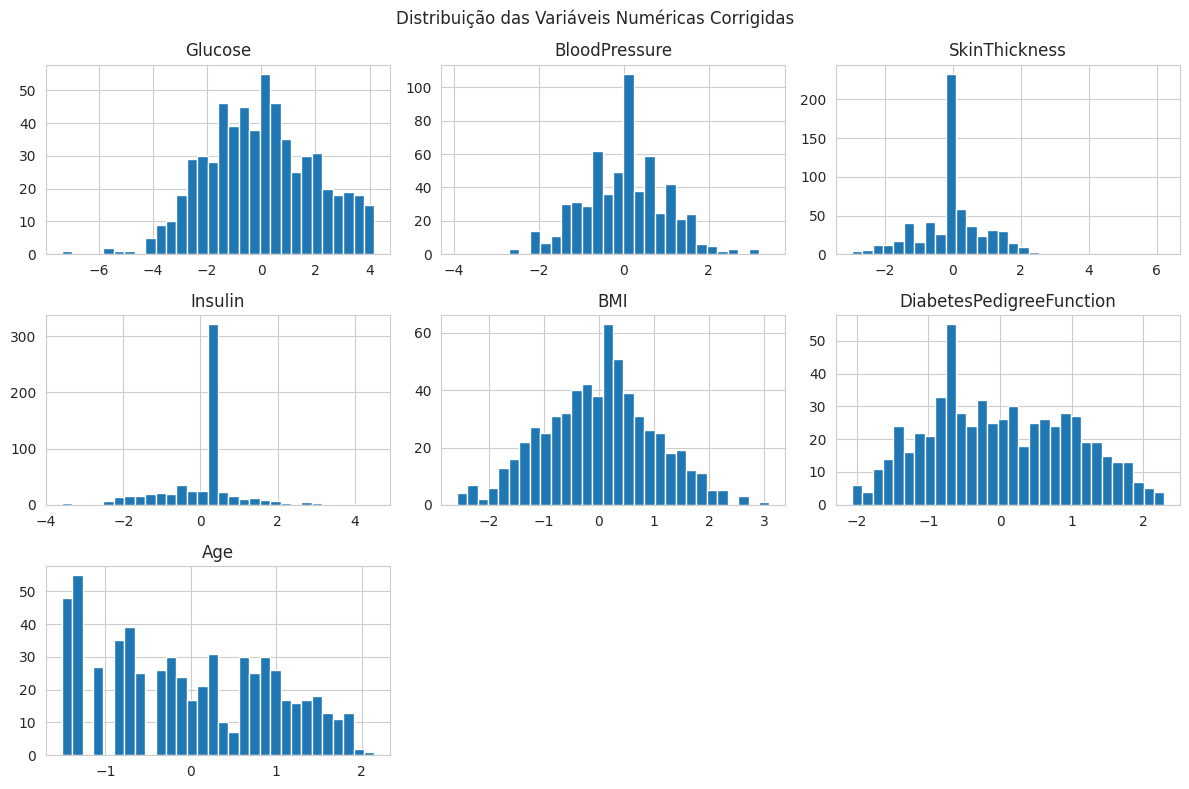

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
train_prepared.hist(bins=30, figsize=(12, 8))
plt.suptitle("Distribuição das Variáveis Numéricas Corrigidas")
plt.tight_layout()

# Models

In [18]:
#Avaliação do Modelo - no pregnancy, with non zero
# Acurácia: 0.7208
# Precisão: 0.6222
# Recall: 0.5185
# F1-Score: 0.5657

#Avaliação do Modelo - no pregnancy, withOUT non zero
#Acurácia: 0.7338
#Precisão: 0.6512
#Recall: 0.5185
#F1-Score: 0.5773

# Avaliação do Modelo - with pregnancy - with non zero
# Acurácia: 0.6948
# Precisão: 0.5778
# Recall: 0.4815
# F1-Score: 0.5253

# Avaliação do Modelo - Sem pipe de NON ZEROS
# Acurácia: 0.7727
# Precisão: 0.7714
# Recall: 0.5000
# F1-Score: 0.6067

# Avaliação do Modelo - Com zero_to_mean antes da pipe
# Acurácia: 0.7857
# Precisão: 0.8182
# Recall: 0.5000
# F1-Score: 0.6207

# Avaliação do Modelo - Com Pipe nonZero e PowerTransformer
# Acurácia: 0.7987
# Precisão: 0.8485
# Recall: 0.5185
# F1-Score: 0.6437

In [95]:
from sklearn.linear_model import LogisticRegression

model_exc(
    LogisticRegression(),
    train_prepared,
    train_labels,
    test_set,
    test_labels,
    num_cols,
)

ModelScore:  0.7207792207792207
Avaliação do Modelo:
Acurácia: 0.6948
Precisão (prever negativos): 0.5432
Recall (prever positivos): 0.8148
F1-Score (equilibrio precisão vs recall): 0.6519

Matriz de Confusão:
 [[63 37]
 [10 44]]


In [96]:
from sklearn.neighbors import KNeighborsClassifier

model_exc(
    KNeighborsClassifier(n_neighbors=9, metric='cosine', weights='distance'),
    train_prepared,
    train_labels,
    test_set,
    test_labels,
    num_cols,
)

ModelScore:  0.7142857142857143
Avaliação do Modelo:
Acurácia: 0.6429
Precisão (prever negativos): 0.4947
Recall (prever positivos): 0.8704
F1-Score (equilibrio precisão vs recall): 0.6309

Matriz de Confusão:
 [[52 48]
 [ 7 47]]


In [97]:
from sklearn import tree

model_exc(
    tree.DecisionTreeRegressor(),
    train_prepared,
    train_labels,
    test_set,
    test_labels,
    num_cols,
)

AttributeError: 'DecisionTreeRegressor' object has no attribute 'predict_proba'

In [107]:
from sklearn.ensemble import RandomForestClassifier

model_exc(
    RandomForestClassifier(n_estimators=14, class_weight="balanced", random_state=42),
    train_prepared,
    train_labels,
    test_set,
    test_labels,
    num_cols,
)

ModelScore:  0.7662337662337663
Avaliação do Modelo:
Acurácia: 0.7273
Precisão (prever negativos): 0.5714
Recall (prever positivos): 0.8889
F1-Score (equilibrio precisão vs recall): 0.6957

Matriz de Confusão:
 [[64 36]
 [ 6 48]]


In [191]:
from sklearn.ensemble import GradientBoostingClassifier

model_exc(
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),
    train_prepared,
    train_labels,
    test_set,
    test_labels,
    num_cols,
)

ModelScore:  0.7792207792207793
Avaliação do Modelo:
Acurácia: 0.7597
Precisão (prever negativos): 0.6133
Recall (prever positivos): 0.8519
F1-Score (equilibrio precisão vs recall): 0.7132

Matriz de Confusão:
 [[71 29]
 [ 8 46]]
